## Load Libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import ReLU, Sequential as Seq, Linear, Parameter, BatchNorm1d, Dropout, ReLU, LeakyReLU, ModuleList,  Embedding
from torch_geometric.nn import GINConv, global_mean_pool,global_max_pool
from torch_geometric.nn.conv import MessagePassing
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required
import math
import numpy as np
from math import sqrt, pi as PI
import pickle
from torch_scatter import scatter
from torch_sparse import SparseTensor
from scipy.optimize import brentq
from scipy import special as sp
from math import *

from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from rdkit.Chem import  MolFromSmiles
from torch_geometric.data import Data
import random
import numpy as np 
import os

from torch_geometric.data import DataLoader
from tqdm import tqdm
import time
import signal
from dimenet_utils import bessel_basis, real_sph_harm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
def swish(x):
    return x * x.sigmoid()

def glorot_orthogonal(tensor, scale):
    if tensor is not None:
        torch.nn.init.orthogonal_(tensor.data)
        scale /= ((tensor.size(-2) + tensor.size(-1)) * tensor.var())
        tensor.data *= scale.sqrt()

try:
    import sympy as sym
except ImportError:
    sym = None

def Jn(r, n):
    # in utiles ok
    return np.sqrt(np.pi / (2 * r)) * sp.jv(n + 0.5, r)

def Jn_zeros(n, k):
    # in utils ok
    zerosj = np.zeros((n, k), dtype='float32')
    zerosj[0] = np.arange(1, k + 1) * np.pi
    points = np.arange(1, k + n) * np.pi
    racines = np.zeros(k + n - 1, dtype='float32')
    for i in range(1, n):
        for j in range(k + n - 1 - i):
            foo = brentq(Jn, points[j], points[j + 1], (i, ))
            racines[j] = foo
        points = racines
        zerosj[i][:k] = racines[:k]
    return zerosj

def spherical_bessel_formulas(n):
    # in utils ok
    x = sym.symbols('x')
    f = [sym.sin(x) / x]
    a = sym.sin(x) / x
    for i in range(1, n):
        b = sym.diff(a, x) / x
        f += [sym.simplify(b * (-x)**i)]
        a = sym.simplify(b)
    return f

def bessel_basis(n, k):
    # in utils ok
    zeros = Jn_zeros(n, k)
    normalizer = []
    for order in range(n):
        normalizer_tmp = []
        for i in range(k):
            normalizer_tmp += [0.5 * Jn(zeros[order, i], order + 1)**2]
        normalizer_tmp = 1 / np.array(normalizer_tmp)**0.5
        normalizer += [normalizer_tmp]

    f = spherical_bessel_formulas(n)
    x = sym.symbols('x')
    bess_basis = []
    for order in range(n):
        bess_basis_tmp = []
        for i in range(k):
            bess_basis_tmp += [
                sym.simplify(normalizer[order][i] *
                             f[order].subs(x, zeros[order, i] * x))
            ]
        bess_basis += [bess_basis_tmp]
    return bess_basis

def sph_harm_prefactor(k, m):
    #  in utils ok
    return ((2 * k + 1) * np.math.factorial(k - abs(m)) /
            (4 * np.pi * np.math.factorial(k + abs(m))))**0.5

def associated_legendre_polynomials(k, zero_m_only=True):
    z = sym.symbols('z')
    P_l_m = [[0] * (j + 1) for j in range(k)]

    P_l_m[0][0] = 1
    if k > 0:
        P_l_m[1][0] = z

        for j in range(2, k):
            P_l_m[j][0] = sym.simplify(((2 * j - 1) * z * P_l_m[j - 1][0] -
                                        (j - 1) * P_l_m[j - 2][0]) / j)
        if not zero_m_only:
            for i in range(1, k):
                P_l_m[i][i] = sym.simplify((1 - 2 * i) * P_l_m[i - 1][i - 1])
                if i + 1 < k:
                    P_l_m[i + 1][i] = sym.simplify(
                        (2 * i + 1) * z * P_l_m[i][i])
                for j in range(i + 2, k):
                    P_l_m[j][i] = sym.simplify(
                        ((2 * j - 1) * z * P_l_m[j - 1][i] -
                         (i + j - 1) * P_l_m[j - 2][i]) / (j - i))

    return P_l_m

def real_sph_harm(k, zero_m_only=True, spherical_coordinates=True):
    if not zero_m_only:
        S_m = [0]
        C_m = [1]
        for i in range(1, k):
            x = sym.symbols('x')
            y = sym.symbols('y')
            S_m += [x * S_m[i - 1] + y * C_m[i - 1]]
            C_m += [x * C_m[i - 1] - y * S_m[i - 1]]

    P_l_m = associated_legendre_polynomials(k, zero_m_only)
    if spherical_coordinates:
        theta = sym.symbols('theta')
        z = sym.symbols('z')
        for i in range(len(P_l_m)):
            for j in range(len(P_l_m[i])):
                if type(P_l_m[i][j]) != int:
                    P_l_m[i][j] = P_l_m[i][j].subs(z, sym.cos(theta))
        if not zero_m_only:
            phi = sym.symbols('phi')
            for i in range(len(S_m)):
                S_m[i] = S_m[i].subs(x,
                                     sym.sin(theta) * sym.cos(phi)).subs(
                                         y,
                                         sym.sin(theta) * sym.sin(phi))
            for i in range(len(C_m)):
                C_m[i] = C_m[i].subs(x,
                                     sym.sin(theta) * sym.cos(phi)).subs(
                                         y,
                                         sym.sin(theta) * sym.sin(phi))

    Y_func_l_m = [['0'] * (2 * j + 1) for j in range(k)]
    for i in range(k):
        Y_func_l_m[i][0] = sym.simplify(sph_harm_prefactor(i, 0) * P_l_m[i][0])

    if not zero_m_only:
        for i in range(1, k):
            for j in range(1, i + 1):
                Y_func_l_m[i][j] = sym.simplify(
                    2**0.5 * sph_harm_prefactor(i, j) * C_m[j] * P_l_m[i][j])
        for i in range(1, k):
            for j in range(1, i + 1):
                Y_func_l_m[i][-j] = sym.simplify(
                    2**0.5 * sph_harm_prefactor(i, -j) * S_m[j] * P_l_m[i][j])

    return Y_func_l_m

class Envelope(torch.nn.Module):
    # Dimenet code adding the last where conditioin like in TF!
    def __init__(self, exponent):
        super(Envelope, self).__init__()
        # +2 instead of +1 to self.p fix partially the "Envelope+BesselBasisLayer" issue reported in Dimenet gitub page.
        self.p = exponent + 2
        self.a = -(self.p + 1) * (self.p + 2) / 2
        self.b = self.p * (self.p + 2)
        self.c = -self.p * (self.p + 1) / 2

    def forward(self, x):
        p, a, b, c = self.p, self.a, self.b, self.c
        x_pow_p0 = x.pow(p - 1)
        x_pow_p1 = x_pow_p0 * x
        x_pow_p2 = x_pow_p1 * x
        env_val =  1. / x + a * x_pow_p0 + b * x_pow_p1 + c * x_pow_p2
        # adding the where condition here was not in the PyG code before!
        return torch.where(x < 1, env_val, torch.zeros_like(x))

class BesselBasisLayer(torch.nn.Module):
    # same as PyG not added the fix yet
    def __init__(self, num_radial, cutoff=5.0, envelope_exponent=5):
        super(BesselBasisLayer, self).__init__()
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)

        self.freq = torch.nn.Parameter(torch.Tensor(num_radial))

        self.reset_parameters()

    def reset_parameters(self):
        torch.arange(1, self.freq.numel() + 1, out=self.freq).mul_(PI)

    def forward(self, dist):
        dist = dist.unsqueeze(-1) / self.cutoff
        # divide by dist fix partially the "Envelope+BesselBasisLayer" issue reported in Dimenet gitub page.
        return (self.envelope(dist) / dist) * (self.freq * dist).sin()


class SphericalBasisLayer(torch.nn.Module):
    # dimenet code ok 
    def __init__(self, num_spherical, num_radial, cutoff=5.0,
                 envelope_exponent=5):
        super(SphericalBasisLayer, self).__init__()
        assert num_radial <= 64
        self.num_spherical = num_spherical
        self.num_radial = num_radial
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)
        
        bessel_forms = bessel_basis(num_spherical, num_radial)
        sph_harm_forms = real_sph_harm(num_spherical)
            
        self.sph_funcs = []
        self.bessel_funcs = []

        x, theta = sym.symbols('x theta')
        modules = {'sin': torch.sin, 'cos': torch.cos}
        for i in range(num_spherical):
            if i == 0:
                sph1 = sym.lambdify([theta], sph_harm_forms[i][0], modules)(0)
                self.sph_funcs.append(lambda x: torch.zeros_like(x) + sph1)

            else:
                sph = sym.lambdify([theta], sph_harm_forms[i][0], modules)
                self.sph_funcs.append(sph)

            for j in range(num_radial):
                bessel = sym.lambdify([x], bessel_forms[i][j], modules)
                self.bessel_funcs.append(bessel)

    def forward(self, dist, angle, idx_kj):
        dist = dist / self.cutoff
        rbf = torch.stack([f(dist) for f in self.bessel_funcs], dim=1)
        rbf = self.envelope(dist).unsqueeze(-1) * rbf

        cbf = torch.stack([f(angle) for f in self.sph_funcs], dim=1)

        n, k = self.num_spherical, self.num_radial

        out = (rbf[idx_kj].view(-1, n, k) * cbf.view(-1, n, 1)).view(-1,   k * n)
        return out

    
class EmbeddingBlock(torch.nn.Module):
    def __init__(self, num_radial, hidden_channels, act=swish):
        super(EmbeddingBlock, self).__init__()
        self.act = act

        self.emb = Embedding(95, hidden_channels)
        self.lin_rbf = Linear(num_radial, hidden_channels)
        self.lin = Linear(3 * hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.emb.weight.data.uniform_(-sqrt(3), sqrt(3))
        glorot_orthogonal(self.lin_rbf.weight, scale=2.)
        glorot_orthogonal(self.lin.weight, scale=2.)
        self.lin_rbf.bias.data.fill_(0)
        self.lin.bias.data.fill_(0)

    def forward(self, x, rbf, i, j):
        # trick to use x format need to convert to long and squeeze the 2nd dim!
        x = self.emb(x.long()).squeeze(1)
        rbf = self.act(self.lin_rbf(rbf))
        x = torch.cat([x[i], x[j], rbf], dim=-1)
        return self.act(self.lin(x))    
    
    
class ResidualLayer(torch.nn.Module):
    # dimenent ok 
    def __init__(self, hidden_channels, act=swish):
        super(ResidualLayer, self).__init__()
        self.act = act
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin1.weight, scale=2.0)
        self.lin1.bias.data.fill_(0)
        glorot_orthogonal(self.lin2.weight, scale=2.0)
        self.lin2.bias.data.fill_(0)

    def forward(self, x):
        return x + self.act(self.lin2(self.act(self.lin1(x))))

class InteractionBlockPP(torch.nn.Module):
    def __init__(self, hidden_channels, int_emb_size, basis_emb_size, num_spherical,
                 num_radial, num_before_skip, num_after_skip, act=swish):
        super(InteractionBlockPP, self).__init__()
        self.act = act
        self.basis_emb_size = basis_emb_size
        self.hidden_channels = hidden_channels
        self.num_spherical = num_spherical
        self.num_radial = num_radial
        
        # Transformations of Bessel and spherical basis representations
        self.lin_rbf = Seq(Linear(num_radial, basis_emb_size, bias=False), Linear(basis_emb_size, hidden_channels, bias=False))
        
        self.lin_sbf = Seq(Linear(num_spherical * num_radial, basis_emb_size ,bias=False),Linear(basis_emb_size, int_emb_size,bias=False)) 

        # Dense transformations of input messages
        self.lin_kj =  Linear(hidden_channels, hidden_channels)
        self.lin_ji =  Linear(hidden_channels, hidden_channels)

        # Embedding projections for interaction triplets
        self.xdownproj =  Linear(hidden_channels, int_emb_size)
        self.xupproj =  Linear(int_emb_size, hidden_channels)
        
        # Residual layers before skip connection
        self.layers_before_skip = torch.nn.ModuleList([
            ResidualLayer(hidden_channels, act) for _ in range(num_before_skip)
        ])
        # final before skip
        self.lin = Linear(hidden_channels, hidden_channels)
        
        # Residual layers after skip connection
        self.layers_after_skip = torch.nn.ModuleList([
            ResidualLayer(hidden_channels, act) for _ in range(num_after_skip)
        ])

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.xdownproj.weight, scale=2.)
        glorot_orthogonal(self.xupproj.weight, scale=2.)
        glorot_orthogonal(self.lin_kj.weight, scale=2.)
        self.lin_kj.bias.data.fill_(0)
        glorot_orthogonal(self.lin_ji.weight, scale=2.)
        self.lin_ji.bias.data.fill_(0)
        #self.W.data.normal_(mean=0, std=2 / self.W.size(0))
        for res_layer in self.layers_before_skip:
            res_layer.reset_parameters()
        glorot_orthogonal(self.lin.weight, scale=2.)
        self.lin.bias.data.fill_(0)
        for res_layer in self.layers_after_skip:
            res_layer.reset_parameters()

    def forward(self, x, rbf, sbf, idx_kj, idx_ji):

        # Initial transformation
        x_ji = self.act(self.lin_ji(x))
        x_kj = self.act(self.lin_kj(x))
        
        # Transform via Bessel basis
        rbf = self.lin_rbf(rbf)
        x_kj = x_kj * rbf # hadamard product

        # Down-project embeddings and generate interaction triplet embeddings
        x_kj = self.act(self.xdownproj(x_kj)) # downproject to 32 as suggested, not sure if needed for scatter (instead they have tensorflow with gather)
        x_kj = x_kj[idx_kj] # == gather()
        
        # Transform via 2D spherical basis
        sbf = self.lin_sbf(sbf)
        x_kj = x_kj * sbf # hadamard product

        # aggregate interactions and up-project embeddings
        x_kj = scatter(x_kj, idx_ji, dim=0, dim_size=x.size(0)) #  same as this one x = tf.math.unsorted_segment_sum(x, idnb_i, n_atoms)
        x_kj = self.act(self.xupproj(x_kj))
        
        # transformations before skip connection            
        x2 = x_ji + x_kj
        for layer in self.layers_before_skip:
            x2 = layer(x2)
            
        # skip connection
        x = x+ self.act(self.lin(x2))
        
        # transformation after skip connection
        for layer in self.layers_after_skip:
            x = layer(x)

        return x

class OutputBlockPP(torch.nn.Module):
    def __init__(self, num_radial, hidden_channels, out_emb_size, out_channels, num_layers,
                 act=swish):
        super(OutputBlockPP, self).__init__()
        self.act = act

        self.lin_rbf = Linear(num_radial, hidden_channels, bias=False)
        self.xupproj = Linear(hidden_channels, out_emb_size, bias=False)

        self.lins = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.lins.append(Linear(out_emb_size, out_emb_size))
        self.final_lin = Linear(out_emb_size, out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin_rbf.weight, scale = 2.0)
        for lin in self.lins:
            glorot_orthogonal(lin.weight, scale = 2.0)
            lin.bias.data.fill_(0)
        self.final_lin.weight.data.fill_(0)

    def forward(self, x, rbf, i, num_nodes=None):
        x = self.lin_rbf(rbf) * x 
        
        x = scatter(x, i, dim=0, dim_size=num_nodes) # x = tf.math.unsorted_segment_sum(x, idnb_i, n_atoms)
        
        x = self.xupproj(x)
        # this imply that the lin have to change to
        for lin in self.lins:
            x = self.act(lin(x)) 
        # return final dense layer done
        return self.final_lin(x)    
    


In [3]:
class DimeNetpp(torch.nn.Module):
    r"""The directional message passing neural network (DimeNet2) from the
    `"Directional Message Passing for Molecular Graphs"
    <https://arxiv.org/abs/2003.03123>`_ paper.
    DimeNet transforms messages based on the angle between them in a
    rotation-equivariant fashion.
    .. note::
        For an example of using DimeNet, see `examples/qm9_dimenet.py
        <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
        qm9_dimenet.py>`_.
    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden embedding size.
        out_channels (int): Size of each output sample.
        num_blocks (int): Number of building blocks.
        num_spherical (int): Number of spherical harmonics.
        num_radial (int): Number of radial basis functions.
        cutoff: (float, optional): Cutoff distance for interatomic
            interactions. (default: :obj:`5.0`)
        envelope_exponent (int, optional): Shape of the smooth cutoff.
            (default: :obj:`5`)
        num_before_skip: (int, optional): Number of residual layers in the
            interaction blocks before the skip connection. (default: :obj:`1`)
        num_after_skip: (int, optional): Number of residual layers in the
            interaction blocks after the skip connection. (default: :obj:`2`)
        num_output_layers: (int, optional): Number of linear layers for the
            output blocks. (default: :obj:`3`)
        act: (function, optional): The activation funtion.
            (default: :obj:`swish`)
    """
    # remove the in_channels in EmbeddingBlock also in the initialization
    def __init__(self, hidden_channels, out_channels, num_blocks,
                 basis_emb_size, num_spherical, num_radial, int_emb_size, out_emb_size, cutoff=5.0,
                 envelope_exponent=5, num_before_skip=1, num_after_skip=2,
                 num_output_layers=3, act=swish):
        super(DimeNetpp, self).__init__()
        

        if sym is None:
            raise ImportError('Package `sympy` could not be found.')

        self.num_blocks = num_blocks

        self.rbf = BesselBasisLayer(num_radial, cutoff, envelope_exponent)
        
        self.sbf = SphericalBasisLayer(num_spherical, num_radial, cutoff,
                                       envelope_exponent)

        # new version remove in_channels!
        self.emb = EmbeddingBlock( num_radial, hidden_channels,
                                  act)
        
        # output block
        self.output_blocks = nn.ModuleList([
            OutputBlockPP(num_radial, hidden_channels, out_emb_size, out_channels,
                        num_output_layers, act) for _ in range(num_blocks + 1)
        ])

        # interaction block
        self.interaction_blocks = nn.ModuleList([
            InteractionBlockPP(hidden_channels,  int_emb_size, basis_emb_size, num_spherical,
                             num_radial, num_before_skip, num_after_skip, act)
            for _ in range(num_blocks)
        ])

        self.reset_parameters()

    def reset_parameters(self):
        self.rbf.reset_parameters()
        self.emb.reset_parameters()
        for out in self.output_blocks:
            out.reset_parameters()
        for interaction in self.interaction_blocks:
            interaction.reset_parameters()

    def triplets(self, edge_index, num_nodes):
        # dimenet ok code
        row, col = edge_index  # j->i

        value = torch.arange(row.size(0), device=row.device)      
        adj_t = SparseTensor(row=col, col=row, value=value,
                             sparse_sizes=(num_nodes, num_nodes))
            
        adj_t_row = adj_t[row]
        num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

        # Node indices (k->j->i) for triplets.
        idx_i = col.repeat_interleave(num_triplets)
        idx_j = row.repeat_interleave(num_triplets)
        idx_k = adj_t_row.storage.col()
        mask = idx_i != idx_k  # Remove i == k triplets.
        idx_i, idx_j, idx_k = idx_i[mask], idx_j[mask], idx_k[mask]

        # Edge indices (k-j, j->i) for triplets.
        idx_kj = adj_t_row.storage.value()[mask]
        idx_ji = adj_t_row.storage.row()[mask]

        return idx_i, idx_j, idx_k, idx_kj, idx_ji

    def forward(self, data):
        """"""
        x, pos, edge_index, batch = data.x, data.pos, data.edge_index, data.batch
        j, i = edge_index
        idx_i, idx_j, idx_k, idx_kj, idx_ji = self.triplets(
            edge_index, num_nodes=x.size(0))

        # Calculate distances.
        dist = (pos[i] - pos[j]).pow(2).sum(dim=-1).sqrt()

        # Calculate angles rigde "values" 
        # there is a bug in the original code reported but not commited! 
        # (thanks to Klicpera Johannes to provide solution)
        pos_i = pos[idx_i]
        pos_j = pos[idx_j]
        pos_ji = pos_j - pos_i
        pos_kj = pos[idx_k] - pos_j # before ki, 
        a = (pos_ji * pos_kj).sum(dim=-1)
        b = torch.cross(pos_ji, pos_kj).norm(dim=-1)
        angle = torch.atan2(b, a)

        rbf = self.rbf(dist)
        sbf = self.sbf(dist, angle, idx_ji) # this idx_kj wrong must be change by idx_ji 
        # (thanks to Klicpera Johannes to provide solution)
        # Embedding block.
        x = self.emb(x, rbf, i, j)
        P = self.output_blocks[0](x, rbf, i, num_nodes=pos.size(0))
        
        # Interaction blocks.
        for interaction_block, output_block in zip(self.interaction_blocks,
                                                   self.output_blocks[1:]):
            x = interaction_block(x, rbf, sbf, idx_kj, idx_ji)
            P += output_block(x, rbf, i)
            
        return P.sum(dim=0) if batch is None else scatter(P, batch, dim=0)


In [4]:
class GenDimenetFeatures(object):
    def __init__(self, cutoff = 5.0):
        self.cutoff = cutoff
        super(GenDimenetFeatures, self).__init__()
        
    def __call__(self, data):
        # important remove the edge_attr not the same size as the cutoff edge of course!
        data.edge_attr = None 

        mol = MolFromSmiles(data.smiles)
        
        m2=Chem.AddHs(mol)
        AllChem.EmbedMolecule(m2, useRandomCoords=True)
        AllChem.MMFFOptimizeMolecule(m2)

        atomic_number = []

        # compute the coordinates
        for c in m2.GetConformers():
            atom_position = c.GetPositions()

        # compute the atomic number
        for atom in m2.GetAtoms():
            atomic_number.append(atom.GetAtomicNum())

        data.x=torch.tensor(np.array(atomic_number), dtype=torch.float).view(-1).unsqueeze(-1)

        data.pos=torch.tensor(atom_position, dtype=torch.float)
        
        # create a new edge index based on cutoff distance
        dist = (data.pos.view(-1, 1, 3) - data.pos.view(1, -1, 3)).norm(dim=-1)
        dist.fill_diagonal_(float('inf'))
        mask = dist <= self.cutoff
        data.edge_index = mask.nonzero().t()

        return data

## Load ESOL

In [5]:
torch.manual_seed(41)
path = '../Dimenetdata3/'
from torch_geometric.datasets import MoleculeNet

dataset = MoleculeNet(path, name='ESOL', pre_transform=GenDimenetFeatures(cutoff = 5.0)).shuffle()

In [6]:
print(dataset)
for data in dataset:
    print(data.keys)
    print(data)
    break

ESOL(1128)
['x', 'edge_index', 'y', 'pos', 'smiles']
Data(edge_index=[2, 382], pos=[24, 3], smiles="Cc1ccc2cc(C)ccc2c1", x=[24, 1], y=[1, 1])


In [7]:
N = len(dataset) // 10
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False )
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
model = DimeNetpp(hidden_channels=128,
                out_channels=1,
                num_blocks=5,
                basis_emb_size = 8,
                num_spherical=7,
                num_radial=6,
                int_emb_size=64,
                out_emb_size=256,
                cutoff=5.0).to(torch.device('cuda:0'))
# cutoff 5.0 normally 

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

In [10]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

rmse = RMSELoss()

def train(loader):
    model.train()
    loss_all = 0
    t = 0
    for l,data in tqdm(enumerate(loader)):
        t+=1
        data = data.to(torch.device('cuda:0'))
        optimizer.zero_grad()
        preds = model.forward(data)
        # compute loss
        loss  = ( preds - data.y ).abs()
        loss_all += loss.detach().sum().item()
        loss.mean().backward()# MAD loss 
        optimizer.step()
        
    return loss_all / len(train_loader.dataset)

### add no grad option here
@torch.no_grad()
def test(loader):
    model.eval()
    error = 0
    for l,data in tqdm(enumerate(loader)):
        data = data.to(torch.device('cuda:0'))
        preds = model.forward(data)
        error += (preds - data.y).abs().sum().item()  # sum AE => SAE
    return error / len(loader.dataset) # MAE (ie mean of the SAE)

@torch.no_grad()
def apply(loader):
    model.eval()
    error = 0
    y_pred = np.array([])
    y_true = np.array([])
    for data in tqdm(loader):
        data = data.to(torch.device('cuda:0'))
        preds = model.forward(data)
        y_pred = np.append(y_pred, preds.cpu().numpy())
        y_true = np.append(y_true, data.y.cpu().numpy())
    return y_pred, y_true

In [11]:
best_val_error = None
for epoch in range(1, 201): # 201
    tic = time.time()
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train(train_loader)
    val_error= test(val_loader)
    test_error = test(test_loader)
    scheduler.step()

    if best_val_error is None or val_error <= best_val_error:
        best_val_error = val_error
    display_time = np.round(time.time()-tic, decimals=2)
    print('Ep: {:03d}, LR: {:4f}, Los: {:.7f}, Val MAE: {:.4f}, '
          'Test MAE: {:.4f}, Time: {:.2f}'.format(epoch, lr, loss, val_error, test_error, display_time))

15it [00:03,  4.05it/s]
2it [00:00, 11.51it/s]
2it [00:00, 12.57it/s]
1it [00:00,  8.10it/s]

Ep: 001, LR: 0.001000, Los: 1456.7701175, Val MAE: 1.3536, Test MAE: 1.5513, Time: 4.05


15it [00:03,  4.48it/s]
2it [00:00, 11.48it/s]
2it [00:00, 12.36it/s]
0it [00:00, ?it/s]

Ep: 002, LR: 0.001000, Los: 1.3931791, Val MAE: 0.8902, Test MAE: 0.9290, Time: 3.69


15it [00:03,  4.50it/s]
2it [00:00, 12.16it/s]
2it [00:00, 12.94it/s]
0it [00:00, ?it/s]

Ep: 003, LR: 0.001000, Los: 0.8805381, Val MAE: 0.9068, Test MAE: 0.8116, Time: 3.66


15it [00:03,  4.44it/s]
2it [00:00, 12.63it/s]
2it [00:00, 12.74it/s]
0it [00:00, ?it/s]

Ep: 004, LR: 0.001000, Los: 0.8015730, Val MAE: 0.7895, Test MAE: 0.7789, Time: 3.71


15it [00:03,  4.46it/s]
2it [00:00, 12.40it/s]
2it [00:00, 13.11it/s]
0it [00:00, ?it/s]

Ep: 005, LR: 0.001000, Los: 0.7703812, Val MAE: 0.7096, Test MAE: 0.6830, Time: 3.69


15it [00:03,  4.49it/s]
2it [00:00, 12.24it/s]
2it [00:00, 13.07it/s]
0it [00:00, ?it/s]

Ep: 006, LR: 0.000999, Los: 0.6843978, Val MAE: 0.7748, Test MAE: 0.7709, Time: 3.66


15it [00:03,  4.47it/s]
2it [00:00, 12.44it/s]
2it [00:00, 12.61it/s]
0it [00:00, ?it/s]

Ep: 007, LR: 0.000999, Los: 0.7334646, Val MAE: 0.6771, Test MAE: 0.7029, Time: 3.69


15it [00:03,  4.59it/s]
2it [00:00, 12.62it/s]
2it [00:00, 12.68it/s]
0it [00:00, ?it/s]

Ep: 008, LR: 0.000999, Los: 0.6628521, Val MAE: 0.8662, Test MAE: 0.7634, Time: 3.59


15it [00:03,  4.42it/s]
2it [00:00, 12.01it/s]
2it [00:00, 12.53it/s]
0it [00:00, ?it/s]

Ep: 009, LR: 0.000998, Los: 0.6710599, Val MAE: 0.8798, Test MAE: 0.8199, Time: 3.73


15it [00:03,  4.38it/s]
2it [00:00, 12.23it/s]
2it [00:00, 13.03it/s]
0it [00:00, ?it/s]

Ep: 010, LR: 0.000998, Los: 0.7519651, Val MAE: 0.7122, Test MAE: 0.7798, Time: 3.75


15it [00:03,  4.38it/s]
2it [00:00, 11.62it/s]
2it [00:00, 11.82it/s]
1it [00:00,  5.05it/s]

Ep: 011, LR: 0.000997, Los: 0.6684397, Val MAE: 0.7541, Test MAE: 0.7582, Time: 3.78


15it [00:03,  4.50it/s]
2it [00:00, 12.21it/s]
2it [00:00, 12.34it/s]
0it [00:00, ?it/s]

Ep: 012, LR: 0.000997, Los: 0.6679898, Val MAE: 0.7951, Test MAE: 0.8319, Time: 3.67


15it [00:03,  4.50it/s]
2it [00:00, 11.52it/s]
2it [00:00, 12.97it/s]
0it [00:00, ?it/s]

Ep: 013, LR: 0.000996, Los: 0.6061766, Val MAE: 0.6662, Test MAE: 0.6112, Time: 3.67


15it [00:03,  4.54it/s]
2it [00:00, 11.89it/s]
2it [00:00, 13.04it/s]
0it [00:00, ?it/s]

Ep: 014, LR: 0.000995, Los: 0.5983881, Val MAE: 0.6086, Test MAE: 0.6131, Time: 3.64


15it [00:03,  4.37it/s]
2it [00:00, 11.43it/s]
2it [00:00, 13.05it/s]
0it [00:00, ?it/s]

Ep: 015, LR: 0.000995, Los: 0.5717445, Val MAE: 0.7109, Test MAE: 0.6737, Time: 3.77


15it [00:03,  4.44it/s]
2it [00:00, 11.34it/s]
2it [00:00, 12.94it/s]
0it [00:00, ?it/s]

Ep: 016, LR: 0.000994, Los: 0.6097495, Val MAE: 0.6936, Test MAE: 0.6199, Time: 3.72


15it [00:03,  4.39it/s]
2it [00:00, 12.37it/s]
2it [00:00, 13.41it/s]
0it [00:00, ?it/s]

Ep: 017, LR: 0.000993, Los: 0.5925091, Val MAE: 0.6612, Test MAE: 0.6653, Time: 3.75


15it [00:03,  4.47it/s]
2it [00:00, 12.14it/s]
2it [00:00, 12.98it/s]
0it [00:00, ?it/s]

Ep: 018, LR: 0.000992, Los: 0.5688523, Val MAE: 0.7505, Test MAE: 0.7217, Time: 3.69


15it [00:03,  4.50it/s]
2it [00:00, 11.90it/s]
2it [00:00, 12.84it/s]
0it [00:00, ?it/s]

Ep: 019, LR: 0.000991, Los: 0.6233198, Val MAE: 0.6326, Test MAE: 0.6016, Time: 3.66


15it [00:03,  4.42it/s]
2it [00:00, 12.70it/s]
2it [00:00, 13.12it/s]
0it [00:00, ?it/s]

Ep: 020, LR: 0.000990, Los: 0.5527209, Val MAE: 0.6775, Test MAE: 0.6395, Time: 3.71


15it [00:03,  4.55it/s]
2it [00:00, 12.70it/s]
2it [00:00, 12.76it/s]
0it [00:00, ?it/s]

Ep: 021, LR: 0.000989, Los: 0.5283645, Val MAE: 0.6073, Test MAE: 0.5741, Time: 3.62


15it [00:03,  4.52it/s]
2it [00:00, 11.86it/s]
2it [00:00, 12.93it/s]
0it [00:00, ?it/s]

Ep: 022, LR: 0.000988, Los: 0.5343728, Val MAE: 0.6702, Test MAE: 0.6384, Time: 3.65


15it [00:03,  4.49it/s]
2it [00:00, 11.88it/s]
2it [00:00, 11.90it/s]
0it [00:00, ?it/s]

Ep: 023, LR: 0.000987, Los: 0.5776143, Val MAE: 0.7387, Test MAE: 0.7551, Time: 3.69


15it [00:03,  4.44it/s]
2it [00:00, 12.73it/s]
2it [00:00, 12.32it/s]
0it [00:00, ?it/s]

Ep: 024, LR: 0.000986, Los: 0.6488891, Val MAE: 0.6459, Test MAE: 0.5774, Time: 3.71


15it [00:03,  4.42it/s]
2it [00:00, 12.55it/s]
2it [00:00, 13.28it/s]
0it [00:00, ?it/s]

Ep: 025, LR: 0.000984, Los: 0.5732912, Val MAE: 0.7234, Test MAE: 0.6431, Time: 3.72


15it [00:03,  4.45it/s]
2it [00:00, 12.21it/s]
2it [00:00, 12.49it/s]
0it [00:00, ?it/s]

Ep: 026, LR: 0.000983, Los: 0.5787849, Val MAE: 0.6909, Test MAE: 0.6387, Time: 3.71


15it [00:03,  4.57it/s]
2it [00:00, 12.61it/s]
2it [00:00, 13.06it/s]
0it [00:00, ?it/s]

Ep: 027, LR: 0.000982, Los: 0.5876083, Val MAE: 0.6082, Test MAE: 0.5410, Time: 3.60


15it [00:03,  4.43it/s]
2it [00:00, 12.66it/s]
2it [00:00, 12.79it/s]
0it [00:00, ?it/s]

Ep: 028, LR: 0.000980, Los: 0.5234396, Val MAE: 0.6426, Test MAE: 0.5162, Time: 3.71


15it [00:03,  4.51it/s]
2it [00:00, 11.95it/s]
2it [00:00, 13.19it/s]
0it [00:00, ?it/s]

Ep: 029, LR: 0.000979, Los: 0.5144872, Val MAE: 0.5866, Test MAE: 0.5782, Time: 3.66


15it [00:03,  4.46it/s]
2it [00:00, 12.07it/s]
2it [00:00, 12.85it/s]
0it [00:00, ?it/s]

Ep: 030, LR: 0.000977, Los: 0.4946272, Val MAE: 0.7007, Test MAE: 0.6437, Time: 3.70


15it [00:03,  4.51it/s]
2it [00:00, 11.71it/s]
2it [00:00, 12.60it/s]
0it [00:00, ?it/s]

Ep: 031, LR: 0.000976, Los: 0.5584705, Val MAE: 0.6165, Test MAE: 0.5560, Time: 3.67


15it [00:03,  4.38it/s]
2it [00:00, 12.26it/s]
2it [00:00, 13.01it/s]
0it [00:00, ?it/s]

Ep: 032, LR: 0.000974, Los: 0.4702355, Val MAE: 0.5891, Test MAE: 0.5344, Time: 3.75


15it [00:03,  4.52it/s]
2it [00:00, 12.67it/s]
2it [00:00, 13.19it/s]
0it [00:00, ?it/s]

Ep: 033, LR: 0.000972, Los: 0.4580977, Val MAE: 0.6858, Test MAE: 0.5381, Time: 3.64


15it [00:03,  4.46it/s]
2it [00:00, 12.43it/s]
2it [00:00, 12.42it/s]
0it [00:00, ?it/s]

Ep: 034, LR: 0.000970, Los: 0.5049063, Val MAE: 0.6508, Test MAE: 0.5790, Time: 3.70


15it [00:03,  4.56it/s]
2it [00:00, 12.50it/s]
2it [00:00, 13.70it/s]
0it [00:00, ?it/s]

Ep: 035, LR: 0.000969, Los: 0.4745373, Val MAE: 0.6046, Test MAE: 0.5409, Time: 3.60


15it [00:03,  4.54it/s]
2it [00:00, 11.64it/s]
2it [00:00, 12.23it/s]
0it [00:00, ?it/s]

Ep: 036, LR: 0.000967, Los: 0.4578982, Val MAE: 0.6031, Test MAE: 0.5318, Time: 3.65


15it [00:03,  4.50it/s]
2it [00:00, 12.64it/s]
2it [00:00, 12.96it/s]
0it [00:00, ?it/s]

Ep: 037, LR: 0.000965, Los: 0.4740229, Val MAE: 0.6029, Test MAE: 0.5795, Time: 3.66


15it [00:03,  4.54it/s]
2it [00:00, 12.46it/s]
2it [00:00, 13.63it/s]
0it [00:00, ?it/s]

Ep: 038, LR: 0.000963, Los: 0.5390376, Val MAE: 0.6111, Test MAE: 0.5778, Time: 3.62


15it [00:03,  4.46it/s]
2it [00:00, 12.15it/s]
2it [00:00, 13.18it/s]
0it [00:00, ?it/s]

Ep: 039, LR: 0.000961, Los: 0.4643209, Val MAE: 0.6345, Test MAE: 0.5436, Time: 3.69


15it [00:03,  4.53it/s]
2it [00:00, 12.41it/s]
2it [00:00, 13.00it/s]
0it [00:00, ?it/s]

Ep: 040, LR: 0.000959, Los: 0.4933325, Val MAE: 0.6645, Test MAE: 0.5615, Time: 3.63


15it [00:03,  4.47it/s]
2it [00:00, 12.69it/s]
2it [00:00, 13.42it/s]
0it [00:00, ?it/s]

Ep: 041, LR: 0.000957, Los: 0.4343598, Val MAE: 0.5659, Test MAE: 0.5144, Time: 3.67


15it [00:03,  4.41it/s]
2it [00:00, 11.99it/s]
2it [00:00, 12.31it/s]
0it [00:00, ?it/s]

Ep: 042, LR: 0.000955, Los: 0.4177923, Val MAE: 0.5805, Test MAE: 0.5236, Time: 3.75


15it [00:03,  4.49it/s]
2it [00:00, 12.07it/s]
2it [00:00, 12.73it/s]
0it [00:00, ?it/s]

Ep: 043, LR: 0.000952, Los: 0.4274054, Val MAE: 0.6078, Test MAE: 0.5173, Time: 3.68


15it [00:03,  4.52it/s]
2it [00:00, 12.03it/s]
2it [00:00, 12.88it/s]
0it [00:00, ?it/s]

Ep: 044, LR: 0.000950, Los: 0.4200435, Val MAE: 0.6171, Test MAE: 0.5074, Time: 3.65


15it [00:03,  4.60it/s]
2it [00:00, 12.20it/s]
2it [00:00, 14.00it/s]
0it [00:00, ?it/s]

Ep: 045, LR: 0.000948, Los: 0.4284834, Val MAE: 0.8198, Test MAE: 0.6808, Time: 3.58


15it [00:03,  4.56it/s]
2it [00:00, 12.27it/s]
2it [00:00, 13.03it/s]
0it [00:00, ?it/s]

Ep: 046, LR: 0.000946, Los: 0.4943889, Val MAE: 0.6174, Test MAE: 0.5064, Time: 3.62


15it [00:03,  4.50it/s]
2it [00:00, 12.36it/s]
2it [00:00, 13.42it/s]
0it [00:00, ?it/s]

Ep: 047, LR: 0.000943, Los: 0.4158278, Val MAE: 0.6433, Test MAE: 0.5385, Time: 3.65


15it [00:03,  4.53it/s]
2it [00:00, 12.23it/s]
2it [00:00, 12.79it/s]
0it [00:00, ?it/s]

Ep: 048, LR: 0.000941, Los: 0.4314962, Val MAE: 0.6084, Test MAE: 0.4830, Time: 3.64


15it [00:03,  4.58it/s]
2it [00:00, 12.32it/s]
2it [00:00, 12.76it/s]
0it [00:00, ?it/s]

Ep: 049, LR: 0.000938, Los: 0.4597125, Val MAE: 0.5947, Test MAE: 0.4881, Time: 3.60


15it [00:03,  4.61it/s]
2it [00:00, 12.22it/s]
2it [00:00, 12.76it/s]
0it [00:00, ?it/s]

Ep: 050, LR: 0.000936, Los: 0.4392188, Val MAE: 0.5785, Test MAE: 0.4794, Time: 3.58


15it [00:03,  4.55it/s]
2it [00:00, 11.56it/s]
2it [00:00, 12.74it/s]
0it [00:00, ?it/s]

Ep: 051, LR: 0.000933, Los: 0.4087213, Val MAE: 0.6046, Test MAE: 0.4692, Time: 3.64


15it [00:03,  4.50it/s]
2it [00:00, 12.19it/s]
2it [00:00, 11.83it/s]
0it [00:00, ?it/s]

Ep: 052, LR: 0.000930, Los: 0.4218362, Val MAE: 0.6041, Test MAE: 0.5826, Time: 3.68


15it [00:03,  4.56it/s]
2it [00:00, 12.83it/s]
2it [00:00, 13.28it/s]
0it [00:00, ?it/s]

Ep: 053, LR: 0.000928, Los: 0.4266169, Val MAE: 0.6901, Test MAE: 0.5226, Time: 3.60


15it [00:03,  4.57it/s]
2it [00:00, 11.97it/s]
2it [00:00, 13.01it/s]
0it [00:00, ?it/s]

Ep: 054, LR: 0.000925, Los: 0.4740519, Val MAE: 0.6583, Test MAE: 0.5484, Time: 3.62


15it [00:03,  4.48it/s]
2it [00:00, 12.40it/s]
2it [00:00, 11.74it/s]
0it [00:00, ?it/s]

Ep: 055, LR: 0.000922, Los: 0.4163737, Val MAE: 0.5648, Test MAE: 0.5087, Time: 3.69


15it [00:03,  4.51it/s]
2it [00:00, 12.43it/s]
2it [00:00, 13.51it/s]
0it [00:00, ?it/s]

Ep: 056, LR: 0.000919, Los: 0.4020878, Val MAE: 0.5691, Test MAE: 0.4811, Time: 3.64


15it [00:03,  4.57it/s]
2it [00:00, 12.87it/s]
2it [00:00, 12.33it/s]
0it [00:00, ?it/s]

Ep: 057, LR: 0.000916, Los: 0.3869117, Val MAE: 0.6015, Test MAE: 0.4642, Time: 3.61


15it [00:03,  4.54it/s]
2it [00:00, 13.04it/s]
2it [00:00, 12.66it/s]
0it [00:00, ?it/s]

Ep: 058, LR: 0.000914, Los: 0.3712049, Val MAE: 0.5779, Test MAE: 0.4855, Time: 3.63


15it [00:03,  4.55it/s]
2it [00:00, 12.73it/s]
2it [00:00, 13.13it/s]
0it [00:00, ?it/s]

Ep: 059, LR: 0.000911, Los: 0.3750318, Val MAE: 0.5328, Test MAE: 0.4375, Time: 3.61


15it [00:03,  4.58it/s]
2it [00:00, 12.24it/s]
2it [00:00, 12.98it/s]
0it [00:00, ?it/s]

Ep: 060, LR: 0.000908, Los: 0.3619624, Val MAE: 0.6815, Test MAE: 0.5628, Time: 3.60


15it [00:03,  4.47it/s]
2it [00:00, 12.09it/s]
2it [00:00, 12.75it/s]
0it [00:00, ?it/s]

Ep: 061, LR: 0.000905, Los: 0.4406010, Val MAE: 0.8015, Test MAE: 0.6227, Time: 3.69


15it [00:03,  4.59it/s]
2it [00:00, 12.44it/s]
2it [00:00, 12.85it/s]
0it [00:00, ?it/s]

Ep: 062, LR: 0.000901, Los: 0.4290417, Val MAE: 0.6030, Test MAE: 0.5017, Time: 3.59


15it [00:03,  4.55it/s]
2it [00:00, 12.59it/s]
2it [00:00, 12.73it/s]
0it [00:00, ?it/s]

Ep: 063, LR: 0.000898, Los: 0.3686290, Val MAE: 0.6039, Test MAE: 0.4944, Time: 3.62


15it [00:03,  4.53it/s]
2it [00:00, 12.11it/s]
2it [00:00, 12.80it/s]
0it [00:00, ?it/s]

Ep: 064, LR: 0.000895, Los: 0.3741594, Val MAE: 0.5228, Test MAE: 0.4402, Time: 3.64


15it [00:03,  4.46it/s]
2it [00:00, 12.22it/s]
2it [00:00, 13.94it/s]
0it [00:00, ?it/s]

Ep: 065, LR: 0.000892, Los: 0.3580811, Val MAE: 0.6163, Test MAE: 0.4621, Time: 3.68


15it [00:03,  4.50it/s]
2it [00:00, 11.50it/s]
2it [00:00, 12.68it/s]
0it [00:00, ?it/s]

Ep: 066, LR: 0.000889, Los: 0.3418746, Val MAE: 0.5928, Test MAE: 0.4567, Time: 3.67


15it [00:03,  4.53it/s]
2it [00:00, 11.73it/s]
2it [00:00, 12.47it/s]
0it [00:00, ?it/s]

Ep: 067, LR: 0.000885, Los: 0.3268599, Val MAE: 0.5458, Test MAE: 0.4987, Time: 3.65


15it [00:03,  4.60it/s]
2it [00:00, 12.38it/s]
2it [00:00, 13.14it/s]
0it [00:00, ?it/s]

Ep: 068, LR: 0.000882, Los: 0.3587024, Val MAE: 0.5623, Test MAE: 0.4809, Time: 3.59


15it [00:03,  4.51it/s]
2it [00:00, 12.51it/s]
2it [00:00, 13.03it/s]
0it [00:00, ?it/s]

Ep: 069, LR: 0.000878, Los: 0.3470553, Val MAE: 0.5458, Test MAE: 0.4556, Time: 3.65


15it [00:03,  4.52it/s]
2it [00:00, 11.86it/s]
2it [00:00, 11.72it/s]
0it [00:00, ?it/s]

Ep: 070, LR: 0.000875, Los: 0.3093051, Val MAE: 0.6040, Test MAE: 0.5025, Time: 3.67


15it [00:03,  4.50it/s]
2it [00:00, 12.30it/s]
2it [00:00, 13.08it/s]
0it [00:00, ?it/s]

Ep: 071, LR: 0.000872, Los: 0.3452158, Val MAE: 0.5674, Test MAE: 0.4607, Time: 3.66


15it [00:03,  4.61it/s]
2it [00:00, 12.85it/s]
2it [00:00, 12.35it/s]
0it [00:00, ?it/s]

Ep: 072, LR: 0.000868, Los: 0.3227026, Val MAE: 0.5782, Test MAE: 0.4756, Time: 3.58


15it [00:03,  4.51it/s]
2it [00:00, 12.79it/s]
2it [00:00, 13.29it/s]
0it [00:00, ?it/s]

Ep: 073, LR: 0.000864, Los: 0.3049622, Val MAE: 0.5803, Test MAE: 0.4330, Time: 3.64


15it [00:03,  4.48it/s]
2it [00:00, 12.28it/s]
2it [00:00, 12.86it/s]
0it [00:00, ?it/s]

Ep: 074, LR: 0.000861, Los: 0.3115765, Val MAE: 0.5756, Test MAE: 0.4707, Time: 3.67


15it [00:03,  4.62it/s]
2it [00:00, 12.36it/s]
2it [00:00, 13.31it/s]
0it [00:00, ?it/s]

Ep: 075, LR: 0.000857, Los: 0.2992341, Val MAE: 0.5657, Test MAE: 0.4836, Time: 3.57


15it [00:03,  4.54it/s]
2it [00:00, 12.15it/s]
2it [00:00, 13.40it/s]
1it [00:00,  5.07it/s]

Ep: 076, LR: 0.000854, Los: 0.3072988, Val MAE: 0.5798, Test MAE: 0.4515, Time: 3.63


15it [00:03,  4.51it/s]
2it [00:00, 12.44it/s]
2it [00:00, 12.88it/s]
0it [00:00, ?it/s]

Ep: 077, LR: 0.000850, Los: 0.3015852, Val MAE: 0.5727, Test MAE: 0.4554, Time: 3.65


15it [00:03,  4.56it/s]
2it [00:00, 12.77it/s]
2it [00:00, 12.86it/s]
0it [00:00, ?it/s]

Ep: 078, LR: 0.000846, Los: 0.3025622, Val MAE: 0.5669, Test MAE: 0.4820, Time: 3.61


15it [00:03,  4.57it/s]
2it [00:00, 12.80it/s]
2it [00:00, 12.93it/s]
0it [00:00, ?it/s]

Ep: 079, LR: 0.000842, Los: 0.3075235, Val MAE: 0.5606, Test MAE: 0.4661, Time: 3.60


15it [00:03,  4.46it/s]
2it [00:00, 12.49it/s]
2it [00:00, 13.59it/s]
0it [00:00, ?it/s]

Ep: 080, LR: 0.000838, Los: 0.2946789, Val MAE: 0.5312, Test MAE: 0.4225, Time: 3.68


15it [00:03,  4.54it/s]
2it [00:00, 12.35it/s]
2it [00:00, 12.64it/s]
0it [00:00, ?it/s]

Ep: 081, LR: 0.000835, Los: 0.2641801, Val MAE: 0.5700, Test MAE: 0.4366, Time: 3.63


15it [00:03,  4.60it/s]
2it [00:00, 12.83it/s]
2it [00:00, 13.10it/s]
0it [00:00, ?it/s]

Ep: 082, LR: 0.000831, Los: 0.3537579, Val MAE: 0.6314, Test MAE: 0.4672, Time: 3.58


15it [00:03,  4.51it/s]
2it [00:00, 12.73it/s]
2it [00:00, 12.99it/s]
0it [00:00, ?it/s]

Ep: 083, LR: 0.000827, Los: 0.3696435, Val MAE: 0.5518, Test MAE: 0.4465, Time: 3.65


15it [00:03,  4.46it/s]
2it [00:00, 12.71it/s]
2it [00:00, 12.92it/s]
0it [00:00, ?it/s]

Ep: 084, LR: 0.000823, Los: 0.3373485, Val MAE: 0.5762, Test MAE: 0.4281, Time: 3.68


15it [00:03,  4.62it/s]
2it [00:00, 12.38it/s]
2it [00:00, 12.88it/s]
0it [00:00, ?it/s]

Ep: 085, LR: 0.000819, Los: 0.2977952, Val MAE: 0.5878, Test MAE: 0.5436, Time: 3.57


15it [00:03,  4.44it/s]
2it [00:00, 12.11it/s]
2it [00:00, 12.18it/s]
0it [00:00, ?it/s]

Ep: 086, LR: 0.000815, Los: 0.3854399, Val MAE: 0.5865, Test MAE: 0.4399, Time: 3.72


15it [00:03,  4.56it/s]
2it [00:00, 11.32it/s]
2it [00:00, 13.33it/s]
0it [00:00, ?it/s]

Ep: 087, LR: 0.000811, Los: 0.3298468, Val MAE: 0.5186, Test MAE: 0.4861, Time: 3.63


15it [00:03,  4.58it/s]
2it [00:00, 13.03it/s]
2it [00:00, 12.98it/s]
0it [00:00, ?it/s]

Ep: 088, LR: 0.000806, Los: 0.3187023, Val MAE: 0.5892, Test MAE: 0.4820, Time: 3.59


15it [00:03,  4.55it/s]
2it [00:00, 11.87it/s]
2it [00:00, 13.13it/s]
0it [00:00, ?it/s]

Ep: 089, LR: 0.000802, Los: 0.2856117, Val MAE: 0.6130, Test MAE: 0.4670, Time: 3.63


15it [00:03,  4.59it/s]
2it [00:00, 12.29it/s]
2it [00:00, 12.68it/s]
0it [00:00, ?it/s]

Ep: 090, LR: 0.000798, Los: 0.3231652, Val MAE: 0.6162, Test MAE: 0.4693, Time: 3.61


15it [00:03,  4.48it/s]
2it [00:00, 12.40it/s]
2it [00:00, 13.14it/s]
0it [00:00, ?it/s]

Ep: 091, LR: 0.000794, Los: 0.3152018, Val MAE: 0.5915, Test MAE: 0.4049, Time: 3.67


15it [00:03,  4.53it/s]
2it [00:00, 12.56it/s]
2it [00:00, 12.28it/s]
0it [00:00, ?it/s]

Ep: 092, LR: 0.000790, Los: 0.2744734, Val MAE: 0.5324, Test MAE: 0.4688, Time: 3.64


15it [00:03,  4.49it/s]
2it [00:00, 11.60it/s]
2it [00:00, 12.97it/s]
0it [00:00, ?it/s]

Ep: 093, LR: 0.000785, Los: 0.2612600, Val MAE: 0.5509, Test MAE: 0.4636, Time: 3.68


15it [00:03,  4.53it/s]
2it [00:00, 11.85it/s]
2it [00:00, 13.17it/s]
0it [00:00, ?it/s]

Ep: 094, LR: 0.000781, Los: 0.2659714, Val MAE: 0.6097, Test MAE: 0.4810, Time: 3.64


15it [00:03,  4.54it/s]
2it [00:00, 12.88it/s]
2it [00:00, 13.69it/s]
0it [00:00, ?it/s]

Ep: 095, LR: 0.000777, Los: 0.2620732, Val MAE: 0.6096, Test MAE: 0.5107, Time: 3.62


15it [00:03,  4.54it/s]
2it [00:00, 12.44it/s]
2it [00:00, 13.19it/s]
0it [00:00, ?it/s]

Ep: 096, LR: 0.000772, Los: 0.3320691, Val MAE: 0.5556, Test MAE: 0.4388, Time: 3.63


15it [00:03,  4.56it/s]
2it [00:00, 12.88it/s]
2it [00:00, 13.43it/s]
0it [00:00, ?it/s]

Ep: 097, LR: 0.000768, Los: 0.2749704, Val MAE: 0.5607, Test MAE: 0.4725, Time: 3.60


15it [00:03,  4.46it/s]
2it [00:00, 12.00it/s]
2it [00:00, 12.27it/s]
0it [00:00, ?it/s]

Ep: 098, LR: 0.000763, Los: 0.2755820, Val MAE: 0.5547, Test MAE: 0.5068, Time: 3.70


15it [00:03,  4.46it/s]
2it [00:00, 12.28it/s]
2it [00:00, 13.14it/s]
0it [00:00, ?it/s]

Ep: 099, LR: 0.000759, Los: 0.2763808, Val MAE: 0.5386, Test MAE: 0.4700, Time: 3.69


15it [00:03,  4.53it/s]
2it [00:00, 12.77it/s]
2it [00:00, 13.09it/s]
0it [00:00, ?it/s]

Ep: 100, LR: 0.000755, Los: 0.2712799, Val MAE: 0.5420, Test MAE: 0.5179, Time: 3.63


15it [00:03,  4.53it/s]
2it [00:00, 12.65it/s]
2it [00:00, 13.24it/s]
1it [00:00,  5.36it/s]

Ep: 101, LR: 0.000750, Los: 0.2715971, Val MAE: 0.5605, Test MAE: 0.4712, Time: 3.63


15it [00:03,  4.62it/s]
2it [00:00, 12.47it/s]
2it [00:00, 13.44it/s]
0it [00:00, ?it/s]

Ep: 102, LR: 0.000745, Los: 0.2708472, Val MAE: 0.5433, Test MAE: 0.4285, Time: 3.57


15it [00:03,  4.57it/s]
2it [00:00, 13.08it/s]
2it [00:00, 12.90it/s]
0it [00:00, ?it/s]

Ep: 103, LR: 0.000741, Los: 0.2389393, Val MAE: 0.5468, Test MAE: 0.4689, Time: 3.60


15it [00:03,  4.58it/s]
2it [00:00, 13.06it/s]
2it [00:00, 13.61it/s]
0it [00:00, ?it/s]

Ep: 104, LR: 0.000736, Los: 0.3162717, Val MAE: 0.5523, Test MAE: 0.4929, Time: 3.58


15it [00:03,  4.53it/s]
2it [00:00, 12.41it/s]
2it [00:00, 12.73it/s]
1it [00:00,  5.05it/s]

Ep: 105, LR: 0.000732, Los: 0.2641990, Val MAE: 0.5391, Test MAE: 0.4983, Time: 3.64


15it [00:03,  4.51it/s]
2it [00:00, 11.47it/s]
2it [00:00, 11.97it/s]
0it [00:00, ?it/s]

Ep: 106, LR: 0.000727, Los: 0.2442996, Val MAE: 0.5377, Test MAE: 0.4437, Time: 3.68


15it [00:03,  4.50it/s]
2it [00:00, 10.92it/s]
2it [00:00, 12.90it/s]
0it [00:00, ?it/s]

Ep: 107, LR: 0.000722, Los: 0.2632476, Val MAE: 0.5443, Test MAE: 0.4651, Time: 3.68


15it [00:03,  4.49it/s]
2it [00:00, 12.12it/s]
2it [00:00, 12.98it/s]
0it [00:00, ?it/s]

Ep: 108, LR: 0.000718, Los: 0.2426314, Val MAE: 0.5765, Test MAE: 0.4472, Time: 3.67


15it [00:03,  4.58it/s]
2it [00:00, 11.99it/s]
2it [00:00, 12.96it/s]
0it [00:00, ?it/s]

Ep: 109, LR: 0.000713, Los: 0.2743286, Val MAE: 0.5911, Test MAE: 0.4557, Time: 3.61


15it [00:03,  4.55it/s]
2it [00:00, 12.80it/s]
2it [00:00, 13.31it/s]
0it [00:00, ?it/s]

Ep: 110, LR: 0.000708, Los: 0.2602072, Val MAE: 0.5412, Test MAE: 0.4487, Time: 3.61


15it [00:03,  4.54it/s]
2it [00:00, 13.50it/s]
2it [00:00, 13.43it/s]
0it [00:00, ?it/s]

Ep: 111, LR: 0.000703, Los: 0.2439193, Val MAE: 0.6320, Test MAE: 0.4860, Time: 3.61


15it [00:03,  4.57it/s]
2it [00:00, 12.45it/s]
2it [00:00, 13.13it/s]
0it [00:00, ?it/s]

Ep: 112, LR: 0.000699, Los: 0.2629014, Val MAE: 0.5941, Test MAE: 0.5095, Time: 3.61


15it [00:03,  4.56it/s]
2it [00:00, 12.24it/s]
2it [00:00, 11.68it/s]
0it [00:00, ?it/s]

Ep: 113, LR: 0.000694, Los: 0.2261340, Val MAE: 0.5224, Test MAE: 0.4627, Time: 3.64


15it [00:03,  4.50it/s]
2it [00:00, 11.83it/s]
2it [00:00, 12.12it/s]
0it [00:00, ?it/s]

Ep: 114, LR: 0.000689, Los: 0.2217367, Val MAE: 0.5175, Test MAE: 0.4377, Time: 3.67


15it [00:03,  4.60it/s]
2it [00:00, 12.70it/s]
2it [00:00, 13.39it/s]
0it [00:00, ?it/s]

Ep: 115, LR: 0.000684, Los: 0.2114294, Val MAE: 0.5351, Test MAE: 0.4354, Time: 3.58


15it [00:03,  4.57it/s]
2it [00:00, 12.94it/s]
2it [00:00, 12.75it/s]
0it [00:00, ?it/s]

Ep: 116, LR: 0.000679, Los: 0.2117154, Val MAE: 0.5576, Test MAE: 0.4709, Time: 3.61


15it [00:03,  4.58it/s]
2it [00:00, 13.00it/s]
2it [00:00, 13.43it/s]
0it [00:00, ?it/s]

Ep: 117, LR: 0.000674, Los: 0.2284010, Val MAE: 0.5655, Test MAE: 0.4709, Time: 3.59


15it [00:03,  4.59it/s]
2it [00:00, 12.89it/s]
2it [00:00, 13.18it/s]
0it [00:00, ?it/s]

Ep: 118, LR: 0.000669, Los: 0.2145934, Val MAE: 0.5570, Test MAE: 0.4639, Time: 3.59


15it [00:03,  4.53it/s]
2it [00:00, 13.22it/s]
2it [00:00, 13.06it/s]
0it [00:00, ?it/s]

Ep: 119, LR: 0.000664, Los: 0.2154440, Val MAE: 0.5547, Test MAE: 0.4620, Time: 3.62


15it [00:03,  4.56it/s]
2it [00:00, 11.96it/s]
2it [00:00, 12.05it/s]
0it [00:00, ?it/s]

Ep: 120, LR: 0.000659, Los: 0.1903735, Val MAE: 0.5282, Test MAE: 0.4214, Time: 3.63


15it [00:03,  4.49it/s]
2it [00:00, 12.52it/s]
2it [00:00, 12.95it/s]
0it [00:00, ?it/s]

Ep: 121, LR: 0.000655, Los: 0.1892250, Val MAE: 0.5411, Test MAE: 0.4604, Time: 3.67


15it [00:03,  4.53it/s]
2it [00:00, 12.65it/s]
2it [00:00, 12.66it/s]
0it [00:00, ?it/s]

Ep: 122, LR: 0.000650, Los: 0.2013903, Val MAE: 0.5757, Test MAE: 0.4607, Time: 3.63


15it [00:03,  4.58it/s]
2it [00:00, 12.27it/s]
2it [00:00, 13.46it/s]
0it [00:00, ?it/s]

Ep: 123, LR: 0.000645, Los: 0.2386721, Val MAE: 0.5427, Test MAE: 0.4401, Time: 3.60


15it [00:03,  4.60it/s]
2it [00:00, 12.42it/s]
2it [00:00, 12.98it/s]
0it [00:00, ?it/s]

Ep: 124, LR: 0.000639, Los: 0.2470895, Val MAE: 0.5826, Test MAE: 0.4584, Time: 3.59


15it [00:03,  4.62it/s]
2it [00:00, 12.58it/s]
2it [00:00, 12.68it/s]
0it [00:00, ?it/s]

Ep: 125, LR: 0.000634, Los: 0.2108422, Val MAE: 0.5656, Test MAE: 0.4323, Time: 3.58


15it [00:03,  4.51it/s]
2it [00:00, 12.37it/s]
2it [00:00, 12.95it/s]
0it [00:00, ?it/s]

Ep: 126, LR: 0.000629, Los: 0.1938490, Val MAE: 0.5448, Test MAE: 0.4283, Time: 3.65


15it [00:03,  4.59it/s]
2it [00:00, 12.48it/s]
2it [00:00, 12.71it/s]
0it [00:00, ?it/s]

Ep: 127, LR: 0.000624, Los: 0.2083067, Val MAE: 0.5595, Test MAE: 0.4436, Time: 3.59


15it [00:03,  4.22it/s]
2it [00:00, 12.81it/s]
2it [00:00, 12.92it/s]
0it [00:00, ?it/s]

Ep: 128, LR: 0.000619, Los: 0.1906000, Val MAE: 0.5797, Test MAE: 0.4324, Time: 3.87


15it [00:03,  4.66it/s]
2it [00:00, 12.68it/s]
2it [00:00, 13.18it/s]
0it [00:00, ?it/s]

Ep: 129, LR: 0.000614, Los: 0.2149459, Val MAE: 0.5594, Test MAE: 0.4458, Time: 3.54


15it [00:03,  4.59it/s]
2it [00:00, 12.53it/s]
2it [00:00, 12.50it/s]
0it [00:00, ?it/s]

Ep: 130, LR: 0.000609, Los: 0.1862130, Val MAE: 0.5461, Test MAE: 0.4359, Time: 3.60


15it [00:03,  4.46it/s]
2it [00:00, 12.86it/s]
2it [00:00, 13.17it/s]
0it [00:00, ?it/s]

Ep: 131, LR: 0.000604, Los: 0.1764405, Val MAE: 0.5621, Test MAE: 0.4436, Time: 3.68


15it [00:03,  4.55it/s]
2it [00:00, 12.55it/s]
2it [00:00, 12.80it/s]
0it [00:00, ?it/s]

Ep: 132, LR: 0.000599, Los: 0.1840543, Val MAE: 0.5523, Test MAE: 0.4356, Time: 3.62


15it [00:03,  4.48it/s]
2it [00:00, 12.31it/s]
2it [00:00, 13.46it/s]
0it [00:00, ?it/s]

Ep: 133, LR: 0.000594, Los: 0.2301890, Val MAE: 0.5901, Test MAE: 0.4516, Time: 3.67


15it [00:03,  4.60it/s]
2it [00:00, 12.34it/s]
2it [00:00, 13.05it/s]
0it [00:00, ?it/s]

Ep: 134, LR: 0.000589, Los: 0.1877425, Val MAE: 0.5515, Test MAE: 0.4658, Time: 3.59


15it [00:03,  4.60it/s]
2it [00:00, 12.57it/s]
2it [00:00, 12.95it/s]
0it [00:00, ?it/s]

Ep: 135, LR: 0.000583, Los: 0.1804490, Val MAE: 0.5562, Test MAE: 0.4331, Time: 3.58


15it [00:03,  4.60it/s]
2it [00:00, 13.11it/s]
2it [00:00, 13.29it/s]
0it [00:00, ?it/s]

Ep: 136, LR: 0.000578, Los: 0.1639727, Val MAE: 0.5485, Test MAE: 0.4495, Time: 3.57


15it [00:03,  4.60it/s]
2it [00:00, 12.21it/s]
2it [00:00, 13.64it/s]
0it [00:00, ?it/s]

Ep: 137, LR: 0.000573, Los: 0.1858998, Val MAE: 0.5715, Test MAE: 0.4239, Time: 3.58


15it [00:03,  4.53it/s]
2it [00:00, 11.64it/s]
2it [00:00, 13.49it/s]
0it [00:00, ?it/s]

Ep: 138, LR: 0.000568, Los: 0.1724536, Val MAE: 0.5486, Test MAE: 0.4498, Time: 3.64


15it [00:03,  4.44it/s]
2it [00:00, 12.87it/s]
2it [00:00, 13.55it/s]
0it [00:00, ?it/s]

Ep: 139, LR: 0.000563, Los: 0.1756726, Val MAE: 0.5638, Test MAE: 0.4330, Time: 3.69


15it [00:03,  4.64it/s]
2it [00:00, 12.65it/s]
2it [00:00, 12.50it/s]
0it [00:00, ?it/s]

Ep: 140, LR: 0.000557, Los: 0.1684582, Val MAE: 0.5576, Test MAE: 0.4207, Time: 3.56


15it [00:03,  4.59it/s]
2it [00:00, 12.71it/s]
2it [00:00, 13.36it/s]
0it [00:00, ?it/s]

Ep: 141, LR: 0.000552, Los: 0.1637677, Val MAE: 0.5616, Test MAE: 0.4713, Time: 3.58


15it [00:03,  4.44it/s]
2it [00:00, 11.68it/s]
2it [00:00, 12.53it/s]
0it [00:00, ?it/s]

Ep: 142, LR: 0.000547, Los: 0.2281607, Val MAE: 0.5497, Test MAE: 0.4407, Time: 3.72


15it [00:03,  4.45it/s]
2it [00:00, 11.28it/s]
2it [00:00, 13.08it/s]
0it [00:00, ?it/s]

Ep: 143, LR: 0.000542, Los: 0.1785778, Val MAE: 0.5513, Test MAE: 0.4316, Time: 3.71


15it [00:03,  4.50it/s]
2it [00:00, 12.93it/s]
2it [00:00, 13.39it/s]
0it [00:00, ?it/s]

Ep: 144, LR: 0.000537, Los: 0.1792964, Val MAE: 0.5240, Test MAE: 0.4146, Time: 3.65


15it [00:03,  4.64it/s]
2it [00:00, 12.73it/s]
2it [00:00, 13.27it/s]
0it [00:00, ?it/s]

Ep: 145, LR: 0.000531, Los: 0.1642152, Val MAE: 0.5890, Test MAE: 0.4592, Time: 3.55


15it [00:03,  4.51it/s]
2it [00:00, 12.43it/s]
2it [00:00, 12.97it/s]
0it [00:00, ?it/s]

Ep: 146, LR: 0.000526, Los: 0.1893442, Val MAE: 0.5813, Test MAE: 0.4521, Time: 3.65


15it [00:03,  4.53it/s]
2it [00:00, 12.20it/s]
2it [00:00, 13.00it/s]
0it [00:00, ?it/s]

Ep: 147, LR: 0.000521, Los: 0.1699476, Val MAE: 0.5757, Test MAE: 0.4253, Time: 3.64


15it [00:03,  4.53it/s]
2it [00:00, 12.47it/s]
2it [00:00, 12.76it/s]
0it [00:00, ?it/s]

Ep: 148, LR: 0.000516, Los: 0.1830619, Val MAE: 0.6029, Test MAE: 0.4936, Time: 3.64


15it [00:03,  4.59it/s]
2it [00:00, 12.51it/s]
2it [00:00, 13.69it/s]
0it [00:00, ?it/s]

Ep: 149, LR: 0.000510, Los: 0.2302364, Val MAE: 0.5566, Test MAE: 0.4496, Time: 3.59


15it [00:03,  4.54it/s]
2it [00:00, 12.59it/s]
2it [00:00, 13.21it/s]
0it [00:00, ?it/s]

Ep: 150, LR: 0.000505, Los: 0.1808334, Val MAE: 0.5438, Test MAE: 0.4519, Time: 3.63


15it [00:03,  4.53it/s]
2it [00:00, 12.60it/s]
2it [00:00, 12.75it/s]
0it [00:00, ?it/s]

Ep: 151, LR: 0.000500, Los: 0.1959484, Val MAE: 0.5520, Test MAE: 0.4408, Time: 3.64


15it [00:03,  4.63it/s]
2it [00:00, 12.65it/s]
2it [00:00, 12.70it/s]
0it [00:00, ?it/s]

Ep: 152, LR: 0.000495, Los: 0.1581421, Val MAE: 0.5328, Test MAE: 0.4262, Time: 3.57


15it [00:03,  4.58it/s]
2it [00:00, 11.17it/s]
2it [00:00, 12.20it/s]
0it [00:00, ?it/s]

Ep: 153, LR: 0.000490, Los: 0.1648594, Val MAE: 0.5424, Test MAE: 0.4450, Time: 3.63


15it [00:03,  4.55it/s]
2it [00:00, 12.59it/s]
2it [00:00, 13.43it/s]
0it [00:00, ?it/s]

Ep: 154, LR: 0.000484, Los: 0.1632622, Val MAE: 0.5584, Test MAE: 0.4405, Time: 3.62


15it [00:03,  4.41it/s]
2it [00:00, 11.60it/s]
2it [00:00, 12.40it/s]
0it [00:00, ?it/s]

Ep: 155, LR: 0.000479, Los: 0.1743000, Val MAE: 0.5614, Test MAE: 0.4099, Time: 3.75


15it [00:03,  4.57it/s]
2it [00:00, 12.98it/s]
2it [00:00, 13.16it/s]
0it [00:00, ?it/s]

Ep: 156, LR: 0.000474, Los: 0.1567616, Val MAE: 0.5583, Test MAE: 0.4292, Time: 3.60


15it [00:03,  4.51it/s]
2it [00:00, 11.91it/s]
2it [00:00, 13.16it/s]
0it [00:00, ?it/s]

Ep: 157, LR: 0.000469, Los: 0.1455884, Val MAE: 0.5359, Test MAE: 0.4213, Time: 3.65


15it [00:03,  4.56it/s]
2it [00:00, 13.11it/s]
2it [00:00, 12.93it/s]
0it [00:00, ?it/s]

Ep: 158, LR: 0.000463, Los: 0.1347557, Val MAE: 0.5411, Test MAE: 0.4335, Time: 3.61


15it [00:03,  4.55it/s]
2it [00:00, 13.22it/s]
2it [00:00, 13.19it/s]
1it [00:00,  5.14it/s]

Ep: 159, LR: 0.000458, Los: 0.1573260, Val MAE: 0.5589, Test MAE: 0.4385, Time: 3.60


15it [00:03,  4.54it/s]
2it [00:00, 12.27it/s]
2it [00:00, 12.41it/s]
0it [00:00, ?it/s]

Ep: 160, LR: 0.000453, Los: 0.1535276, Val MAE: 0.5433, Test MAE: 0.4380, Time: 3.64


15it [00:03,  4.52it/s]
2it [00:00, 12.61it/s]
2it [00:00, 13.50it/s]
0it [00:00, ?it/s]

Ep: 161, LR: 0.000448, Los: 0.1626756, Val MAE: 0.5515, Test MAE: 0.4455, Time: 3.63


15it [00:03,  4.64it/s]
2it [00:00, 12.90it/s]
2it [00:00, 12.93it/s]
0it [00:00, ?it/s]

Ep: 162, LR: 0.000443, Los: 0.1633267, Val MAE: 0.5365, Test MAE: 0.4231, Time: 3.55


15it [00:03,  4.60it/s]
2it [00:00, 12.62it/s]
2it [00:00, 12.87it/s]
0it [00:00, ?it/s]

Ep: 163, LR: 0.000437, Los: 0.1510023, Val MAE: 0.5891, Test MAE: 0.4431, Time: 3.59


15it [00:03,  4.49it/s]
2it [00:00, 12.41it/s]
2it [00:00, 13.20it/s]
0it [00:00, ?it/s]

Ep: 164, LR: 0.000432, Los: 0.1634577, Val MAE: 0.5669, Test MAE: 0.4353, Time: 3.66


15it [00:03,  4.49it/s]
2it [00:00, 11.35it/s]
2it [00:00, 11.73it/s]
0it [00:00, ?it/s]

Ep: 165, LR: 0.000427, Los: 0.1671508, Val MAE: 0.5751, Test MAE: 0.4536, Time: 3.70


15it [00:03,  4.49it/s]
2it [00:00, 12.63it/s]
2it [00:00, 13.63it/s]
0it [00:00, ?it/s]

Ep: 166, LR: 0.000422, Los: 0.1875712, Val MAE: 0.5834, Test MAE: 0.4266, Time: 3.66


15it [00:03,  4.54it/s]
2it [00:00, 12.20it/s]
2it [00:00, 12.71it/s]
0it [00:00, ?it/s]

Ep: 167, LR: 0.000417, Los: 0.1869342, Val MAE: 0.5671, Test MAE: 0.4261, Time: 3.64


15it [00:03,  4.44it/s]
2it [00:00, 12.98it/s]
2it [00:00, 12.72it/s]
0it [00:00, ?it/s]

Ep: 168, LR: 0.000411, Los: 0.1874713, Val MAE: 0.6005, Test MAE: 0.4724, Time: 3.70


15it [00:03,  4.43it/s]
2it [00:00, 12.50it/s]
2it [00:00, 13.28it/s]
0it [00:00, ?it/s]

Ep: 169, LR: 0.000406, Los: 0.1585216, Val MAE: 0.5761, Test MAE: 0.4317, Time: 3.70


15it [00:03,  4.52it/s]
2it [00:00, 12.15it/s]
2it [00:00, 12.48it/s]
0it [00:00, ?it/s]

Ep: 170, LR: 0.000401, Los: 0.1267060, Val MAE: 0.5778, Test MAE: 0.4549, Time: 3.65


15it [00:03,  4.50it/s]
2it [00:00, 11.97it/s]
2it [00:00, 13.38it/s]
1it [00:00,  5.40it/s]

Ep: 171, LR: 0.000396, Los: 0.1399270, Val MAE: 0.5616, Test MAE: 0.4129, Time: 3.66


15it [00:03,  4.54it/s]
2it [00:00, 12.25it/s]
2it [00:00, 13.81it/s]
0it [00:00, ?it/s]

Ep: 172, LR: 0.000391, Los: 0.1336916, Val MAE: 0.5804, Test MAE: 0.4319, Time: 3.62


15it [00:03,  4.54it/s]
2it [00:00, 12.08it/s]
2it [00:00, 11.90it/s]
0it [00:00, ?it/s]

Ep: 173, LR: 0.000386, Los: 0.1417178, Val MAE: 0.5628, Test MAE: 0.4479, Time: 3.64


15it [00:03,  4.51it/s]
2it [00:00, 12.44it/s]
2it [00:00, 12.84it/s]
0it [00:00, ?it/s]

Ep: 174, LR: 0.000381, Los: 0.1569345, Val MAE: 0.5702, Test MAE: 0.4161, Time: 3.65


15it [00:03,  4.47it/s]
2it [00:00, 11.90it/s]
2it [00:00, 12.64it/s]
0it [00:00, ?it/s]

Ep: 175, LR: 0.000376, Los: 0.1560841, Val MAE: 0.5727, Test MAE: 0.4341, Time: 3.69


15it [00:03,  4.45it/s]
2it [00:00, 12.11it/s]
2it [00:00, 13.08it/s]
0it [00:00, ?it/s]

Ep: 176, LR: 0.000371, Los: 0.1670358, Val MAE: 0.5747, Test MAE: 0.4334, Time: 3.69


15it [00:03,  4.50it/s]
2it [00:00, 12.18it/s]
2it [00:00, 13.43it/s]
0it [00:00, ?it/s]

Ep: 177, LR: 0.000366, Los: 0.1436910, Val MAE: 0.5742, Test MAE: 0.4510, Time: 3.66


15it [00:03,  4.52it/s]
2it [00:00, 12.40it/s]
2it [00:00, 13.01it/s]
0it [00:00, ?it/s]

Ep: 178, LR: 0.000361, Los: 0.1325877, Val MAE: 0.5693, Test MAE: 0.4206, Time: 3.65


15it [00:03,  4.62it/s]
2it [00:00, 12.29it/s]
2it [00:00, 12.95it/s]
0it [00:00, ?it/s]

Ep: 179, LR: 0.000355, Los: 0.1399663, Val MAE: 0.5631, Test MAE: 0.4434, Time: 3.57


15it [00:03,  4.40it/s]
2it [00:00, 12.52it/s]
2it [00:00, 12.33it/s]
0it [00:00, ?it/s]

Ep: 180, LR: 0.000350, Los: 0.1296432, Val MAE: 0.5706, Test MAE: 0.4289, Time: 3.74


15it [00:03,  4.52it/s]
2it [00:00, 12.49it/s]
2it [00:00, 13.09it/s]
0it [00:00, ?it/s]

Ep: 181, LR: 0.000345, Los: 0.1345555, Val MAE: 0.5606, Test MAE: 0.4261, Time: 3.64


15it [00:03,  4.49it/s]
2it [00:00, 12.04it/s]
2it [00:00, 13.18it/s]
0it [00:00, ?it/s]

Ep: 182, LR: 0.000341, Los: 0.1159804, Val MAE: 0.5637, Test MAE: 0.4379, Time: 3.67


15it [00:03,  4.51it/s]
2it [00:00, 12.58it/s]
2it [00:00, 13.01it/s]
0it [00:00, ?it/s]

Ep: 183, LR: 0.000336, Los: 0.1208617, Val MAE: 0.5396, Test MAE: 0.4119, Time: 3.65


15it [00:03,  4.52it/s]
2it [00:00, 12.16it/s]
2it [00:00, 13.22it/s]
0it [00:00, ?it/s]

Ep: 184, LR: 0.000331, Los: 0.1163835, Val MAE: 0.5555, Test MAE: 0.4346, Time: 3.64


15it [00:03,  4.61it/s]
2it [00:00, 12.61it/s]
2it [00:00, 13.56it/s]
0it [00:00, ?it/s]

Ep: 185, LR: 0.000326, Los: 0.1069434, Val MAE: 0.5492, Test MAE: 0.4133, Time: 3.57


15it [00:03,  4.58it/s]
2it [00:00, 12.00it/s]
2it [00:00, 12.89it/s]
0it [00:00, ?it/s]

Ep: 186, LR: 0.000321, Los: 0.1179189, Val MAE: 0.5696, Test MAE: 0.4239, Time: 3.61


15it [00:03,  4.49it/s]
2it [00:00, 12.36it/s]
2it [00:00, 13.07it/s]
0it [00:00, ?it/s]

Ep: 187, LR: 0.000316, Los: 0.1138427, Val MAE: 0.5522, Test MAE: 0.4291, Time: 3.67


15it [00:03,  4.56it/s]
2it [00:00, 12.69it/s]
2it [00:00, 13.02it/s]
0it [00:00, ?it/s]

Ep: 188, LR: 0.000311, Los: 0.1039983, Val MAE: 0.5669, Test MAE: 0.4222, Time: 3.61


15it [00:03,  4.50it/s]
2it [00:00, 12.03it/s]
2it [00:00, 12.46it/s]
0it [00:00, ?it/s]

Ep: 189, LR: 0.000306, Los: 0.1159475, Val MAE: 0.5552, Test MAE: 0.4282, Time: 3.67


15it [00:03,  4.47it/s]
2it [00:00, 12.48it/s]
2it [00:00, 13.33it/s]
0it [00:00, ?it/s]

Ep: 190, LR: 0.000301, Los: 0.1113321, Val MAE: 0.5613, Test MAE: 0.4315, Time: 3.68


15it [00:03,  4.52it/s]
2it [00:00, 12.59it/s]
2it [00:00, 12.45it/s]
0it [00:00, ?it/s]

Ep: 191, LR: 0.000297, Los: 0.0966118, Val MAE: 0.5537, Test MAE: 0.4192, Time: 3.64


15it [00:03,  4.45it/s]
2it [00:00, 11.86it/s]
2it [00:00, 13.05it/s]
1it [00:00,  5.14it/s]

Ep: 192, LR: 0.000292, Los: 0.1101479, Val MAE: 0.5834, Test MAE: 0.4461, Time: 3.70


15it [00:03,  4.54it/s]
2it [00:00, 12.75it/s]
2it [00:00, 13.57it/s]
0it [00:00, ?it/s]

Ep: 193, LR: 0.000287, Los: 0.1083156, Val MAE: 0.5631, Test MAE: 0.4275, Time: 3.62


15it [00:03,  4.61it/s]
2it [00:00, 11.29it/s]
2it [00:00, 13.56it/s]
0it [00:00, ?it/s]

Ep: 194, LR: 0.000282, Los: 0.0991230, Val MAE: 0.5646, Test MAE: 0.4236, Time: 3.59


15it [00:03,  4.50it/s]
2it [00:00, 12.65it/s]
2it [00:00, 12.82it/s]
0it [00:00, ?it/s]

Ep: 195, LR: 0.000278, Los: 0.0956832, Val MAE: 0.5615, Test MAE: 0.4172, Time: 3.65


15it [00:03,  4.47it/s]
2it [00:00, 11.87it/s]
2it [00:00, 13.47it/s]
0it [00:00, ?it/s]

Ep: 196, LR: 0.000273, Los: 0.1005503, Val MAE: 0.5601, Test MAE: 0.4232, Time: 3.68


15it [00:03,  4.50it/s]
2it [00:00, 12.63it/s]
2it [00:00, 12.97it/s]
0it [00:00, ?it/s]

Ep: 197, LR: 0.000268, Los: 0.0908926, Val MAE: 0.5690, Test MAE: 0.4320, Time: 3.65


15it [00:03,  4.63it/s]
2it [00:00, 12.56it/s]
2it [00:00, 13.67it/s]
0it [00:00, ?it/s]

Ep: 198, LR: 0.000264, Los: 0.0958288, Val MAE: 0.5707, Test MAE: 0.4203, Time: 3.55


15it [00:03,  4.78it/s]
2it [00:00, 12.02it/s]
2it [00:00, 13.11it/s]
0it [00:00, ?it/s]

Ep: 199, LR: 0.000259, Los: 0.0977847, Val MAE: 0.5474, Test MAE: 0.4152, Time: 3.47


15it [00:03,  4.56it/s]
2it [00:00, 13.37it/s]
2it [00:00, 13.45it/s]

Ep: 200, LR: 0.000255, Los: 0.0859672, Val MAE: 0.5548, Test MAE: 0.4208, Time: 3.60


In [12]:
yp, yt = apply(test_loader)
yp, yt = yt.ravel(), yp.ravel()

100%|██████████| 2/2 [00:00<00:00, 12.86it/s]


In [13]:
r2T = r2_score(yt, yp)
rmseT = np.sqrt(mean_squared_error(yt, yp))
mae = mean_absolute_error(yt,yp)
print(r2T, rmseT, mae)

0.9279238160041559 0.5795739577678096 0.4207655161818756


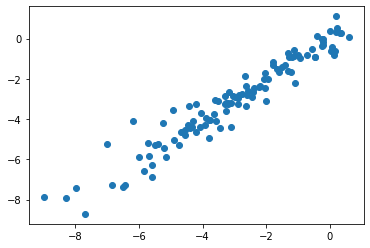

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(yt, yp)
plt.show()